This analysis is **heavily** adapted from [this tutorial](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/) on how to apply LSTMs in Python and [this blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) describing how RNNs and LSTMs work.

Now we will a type of recurrent neural networks (RNNs) known as long short term memory (LSTM) to predict electricity demand from weather features. Whereas traditional NNs have no baseline sense of temporality, RNNs include loops, allowing information to persist across multiple timesteps. **Figure 1** shows an unraveled RNN and demonstrates how information persists through time; by supplying the output of a previous timestep to the input of the current timestep, past information is used to predict the future.

!["An unrolled RNN"](RNN-unrolled.png "Unrolled RNN")

### Figure 1: Unraveled RNN

One issue with RNNs are long-term dependencies: it's difficult for RNNs to recall pertinent information from timesteps far away from the current timestep. Resultingly, LSTM networks were desdigned by [Hochreiter & Schmidhuber (1997)](http://www.bioinf.jku.at/publications/older/2604.pdf) to allow for long-term dependencies. **Figure 2** shows the internal structure of an LSTM, each part of which will be discussed below.
!["LSTM"](LSTM-chain.png "LSTM diagram")

### Figure 2: LSTM diagram. The pink icons represent matrix transformations (addition, multiplication, tanh) while the yellow icons represent different network layers

The main idea behind LSTMs is the cell state: the horizontal line running across the top of the LSTM cell. Crucially, the LSTM has the ability to add or remove information from the cell state through structures called gates.

Data flows through the layers of an LSTM in a sequence of steps:
1. First the forget gate layer, which looks at the previous LSTMs output and the current input and decides how much information should be removed from the cell state between timesteps.
2. Second the input gate layer, which decides which values to update and importantly *how much* to update each value in the cell state.
3. Third the tanh layer, which creates a vector of candidate information to be possibly added to the cell state.
4. Fourth we combine the previous steps by first removing the information we decided to forget in step one and then adding the candidate values decided in step three scaled by how much we decided to update each state value in step two. The product here is the new cell state, which will be transfered to the subsequent LSTM.
5. Finally we decide what to output ($h_t$ in the diagram). The output will be based on our cell state, but filtered according to which information we decided to add and remove before.

This is a rudimentary overview of RNNs and LSTMs. For a more in-depth, mathematical review, check out the blog post linked at the top. Now we apply LSTMs to predict electricity demand from weather features.

In [8]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
def series_to_supervised(data, col_names, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [2]:
WORKING_DIR = '/Users/rvg/Documents/springboard_ds/springboard_portfolio/Electricity_Demand/'

la_df = pd.read_pickle(WORKING_DIR + 'data/LA_df.pkl')

seattle_df = pd.read_pickle(WORKING_DIR + 'data/seattle_df.pkl')

#the following example will be with the LA dataset only
dataset = la_df.copy()

# set the column we want to predict (demand) to the first columns for consistency with the tutorial
cols = list(dataset.columns)
cols.remove('demand')
cols.insert(0,'demand')
dataset = dataset[cols]

## Preparing data for LSTM

The first step is to prepare the dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the electricity demand at the current hour (t) given the electricity demand and weather conditions at the prior time step.

In [6]:
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, dataset.columns, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.head())

   demand(t-1)  hourlyvisibility(t-1)  hourlydewpointtempf(t-1)  \
1     0.237244                      1                  0.915663   
2     0.186420                      1                  0.927711   
3     0.155685                      1                  0.915663   
4     0.134592                      1                  0.891566   
5     0.135195                      1                  0.891566   

   hourlyrelativehumidity(t-1)  hourlywindspeed(t-1)  \
1                     0.680412                   0.0   
2                     0.628866                   0.0   
3                     0.515464                   0.0   
4                     0.443299                   0.2   
5                     0.494845                   0.2   

   hourlystationpressure(t-1)  hourlyprecip(t-1)  dailyheatingdegreedays(t-1)  \
1                    0.466019                  0                            0   
2                    0.466019                  0                            0   
3                

## Define and Fit Model

In this section, we will fit an LSTM on the multivariate input data.

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining data.

We split the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [7]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((8760, 1, 17), (8760,), (18294, 1, 17), (18294,))


Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting electricity demand. The input shape will be 1 time step with 17 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Epochs Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

Train on 8760 samples, validate on 18294 samples
Epoch 1/50
 - 1s - loss: 0.0843 - val_loss: 0.0817
Epoch 2/50
 - 0s - loss: 0.0601 - val_loss: 0.0705
Epoch 3/50
 - 0s - loss: 0.0504 - val_loss: 0.0541
Epoch 4/50
 - 0s - loss: 0.0404 - val_loss: 0.0397
Epoch 5/50
 - 1s - loss: 0.0328 - val_loss: 0.0344
Epoch 6/50
 - 1s - loss: 0.0290 - val_loss: 0.0268
Epoch 7/50
 - 1s - loss: 0.0266 - val_loss: 0.0265
Epoch 8/50
 - 0s - loss: 0.0254 - val_loss: 0.0253
Epoch 9/50
 - 0s - loss: 0.0247 - val_loss: 0.0256
Epoch 10/50
 - 0s - loss: 0.0244 - val_loss: 0.0262
Epoch 11/50
 - 0s - loss: 0.0242 - val_loss: 0.0266
Epoch 12/50
 - 0s - loss: 0.0240 - val_loss: 0.0282
Epoch 13/50
 - 0s - loss: 0.0237 - val_loss: 0.0278
Epoch 14/50
 - 0s - loss: 0.0235 - val_loss: 0.0281
Epoch 15/50
 - 1s - loss: 0.0233 - val_loss: 0.0279
Epoch 16/50
 - 1s - loss: 0.0233 - val_loss: 0.0280
Epoch 17/50
 - 1s - loss: 0.0231 - val_loss: 0.0282
Epoch 18/50
 - 1s - loss: 0.0230 - val_loss: 0.0286
Epoch 19/50
 - 0s - loss

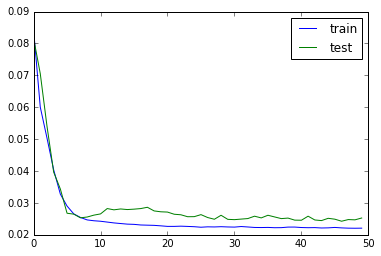

In [9]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

## Evaluate Model

After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [10]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 162.823


The RMSE on the test set is quite remarkable--it's almost half the RMSE of our best supervised learning algorithm! (Bagging, ~300)